# Time-series prediction of renewable energy production

Applying the model to new data.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from scipy.signal import savgol_filter

Using TensorFlow backend.
/home/johannes/.virtualenvs/renewables_notebooks/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
# fix seed to make results reproducible
np.random.seed(7)

In [3]:
data = pd.read_csv('../data/generation_2018.csv').set_index('timestamp')

In [4]:
model = load_model('model_lstm_32.h5')

In [5]:
def create_datasets(ds, lookback=1):
    """
    Create two datasets for training: X = input, Y = output.
    X is three-dimensional: num_samples, lookback_range, num_features.
    Y is two-dimensional: num_samples, num_features. 
    The lookback argument tells us how many samples to scan back.
    """
    acc_x, acc_y = [], []
    for i in range(len(ds) - lookback):
        acc_x.append(ds[i:i + lookback])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)

In [6]:
lookback = 5

# select the columns we are interested in to model
orig_df = data[['renewables', 'non_renewables']]
dataset = orig_df.as_matrix()

# scaling to [0, 1] is essential for LSTM training
# NOTE: seems to be better to create a new scaler, instead of loading the scaler used for model training
scaler = MinMaxScaler(feature_range=[0, 1])
dataset = scaler.fit_transform(dataset)

test_x, _ = create_datasets(dataset, lookback)

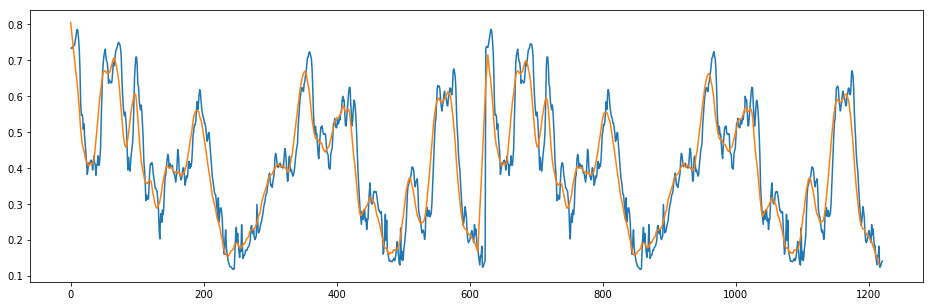

In [10]:
p = model.predict(test_x)
p_mw = scaler.inverse_transform(p)
p_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in p_mw]
p_ratio = savgol_filter(p_ratio, 15, 1)

# drop timeframe amount equal to lookback from beginning of real, verification data.
# we are producing predictions from the get-go in p_ratio. First point to plot should
# be the first real data point that corresponds to a prediction.
real = orig_df.apply(pd.Series).reset_index(drop=True).drop([0, lookback])
real['ratio'] = real['renewables'] / (real['renewables'] + real['non_renewables'])

plt.plot(real['ratio'])
plt.plot(p_ratio)
plt.show()

In [11]:
def extend_prediction(model, x, t=1):
    """Returns X suitable for predicting t+1"""
    rows, lookback, _ = x.shape
    assert t < lookback, "Resulting X must retain at least one non-predicted value"
    x_t = x.copy()
    roll_one = lambda arr: np.roll(arr, -1, axis=1)
    for i in range(1, t + 1):
        p = model.predict(x_t)
        x_t = roll_one(x_t)
        for row in range(rows):
            x_t[row, 2] = p[row]
    return model.predict(x_t)

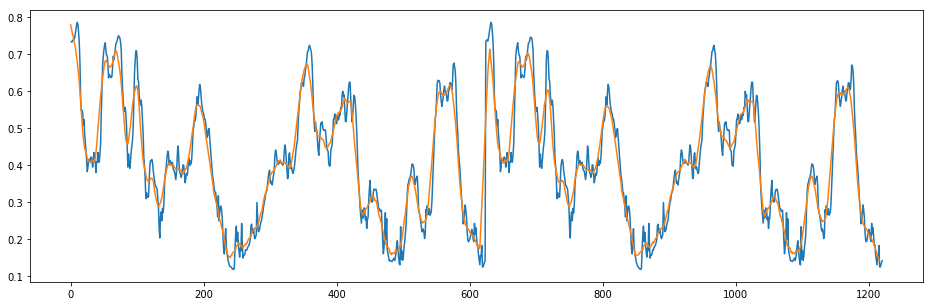

In [12]:
p_t3 = extend_prediction(model, test_x, t = 2)
p_t3_mw = scaler.inverse_transform(p_t3)
p_t3_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in p_t3_mw]
p_t3_ratio = savgol_filter(p_t3_ratio, 15, 1)

plt.plot(real['ratio'])
plt.plot(p_t3_ratio)
plt.show()

In [30]:
",".join(map(str, p_t3_ratio[-48:-21]))

'0.609024,0.610106,0.604062,0.595785,0.586156,0.572461,0.555949,0.539961,0.520175,0.499054,0.47759,0.455587,0.428609,0.400047,0.375179,0.353181,0.332125,0.315488,0.298265,0.28276,0.270644,0.259217,0.249095,0.242276,0.23805,0.234499,0.230193'